In [80]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

%matplotlib inline
sns.set(
     font_scale=1.2,
     style="whitegrid",
     rc={'figure.figsize':(16, 12)}
         )

В этом проекте применим линейную регрессию на практике – попробуем предсказать стоимость машин и понять, от каких факторов зависит ценообразование на автомобили. Помимо этого узнаем, какие переменные важны для прогнозирования и насколько хорошо полученная модель описывает данные. 

### 1.

Загружаем данные, проверяем типы, пропущенные значения. 

Сколько пропущенных значений встретилось в датасете?


In [81]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/387691/cars.csv')

In [82]:
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [83]:
df.isna().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

В дадасете нет пропущенных значений.

### 2.

Сгенерируем первый признак.

Использовать полное название машины – не самый хороший вариант, поэтому создадим новый признак – марку автомобиля (company). Для этого используем столбец `CarName`, разозьем значения ячеек по пробелу и запишем в колонку первый элемент. Например:

`'audi 100 ls' → 'audi'`

Сколько всего уникальных марок машины встречается в датасете? Столбец `CarName` с полным названием машины удалим из датасета, а также `car_ID`, они не пригодятся для дальнейшего анализа.


In [85]:
# Создаем новый столбец company.
df['company'] = df.CarName.str.split().str[0]

In [86]:
print('Уникальных марок машин в датасете:', df.company.nunique())

Уникальных марок машин в датасете: 28


In [87]:
# Удаляем из датасета столбцы 'CarName' и 'car_ID'.
df.drop(columns=['CarName', 'car_ID'], inplace=True)

 ### 3

Теперь внимательнее посмотрим на уникальные значения company. Часть из них оказалась с ошибками!

    'maxda' → 'mazda'
    'Nissan' → 'nissan'
    'porcshce' → 'porsche'
    'toyouta' → 'toyota'
    'vokswagen' & 'vw' → 'volkswagen'

Сколько уникальных производителей осталось в итоге?


In [88]:
# Исправлем ошибки в названиях марок машин.
df.company = df.company\
    .str.replace('maxda', 'mazda')\
    .str.replace('Nissan', 'nissan')\
    .str.replace('porcshce', 'porsche')\
    .str.replace('toyouta', 'toyota')\
    .str.replace('vokswagen', 'volkswagen')\
    .str.replace('vw', 'volkswagen')

In [89]:
print('Уникальных марок машин в датасете:', df.company.nunique())

Уникальных марок машин в датасете: 22


### 3.

Самое время посмотреть на связи между предикторами. Построим `sns.pairplot`.

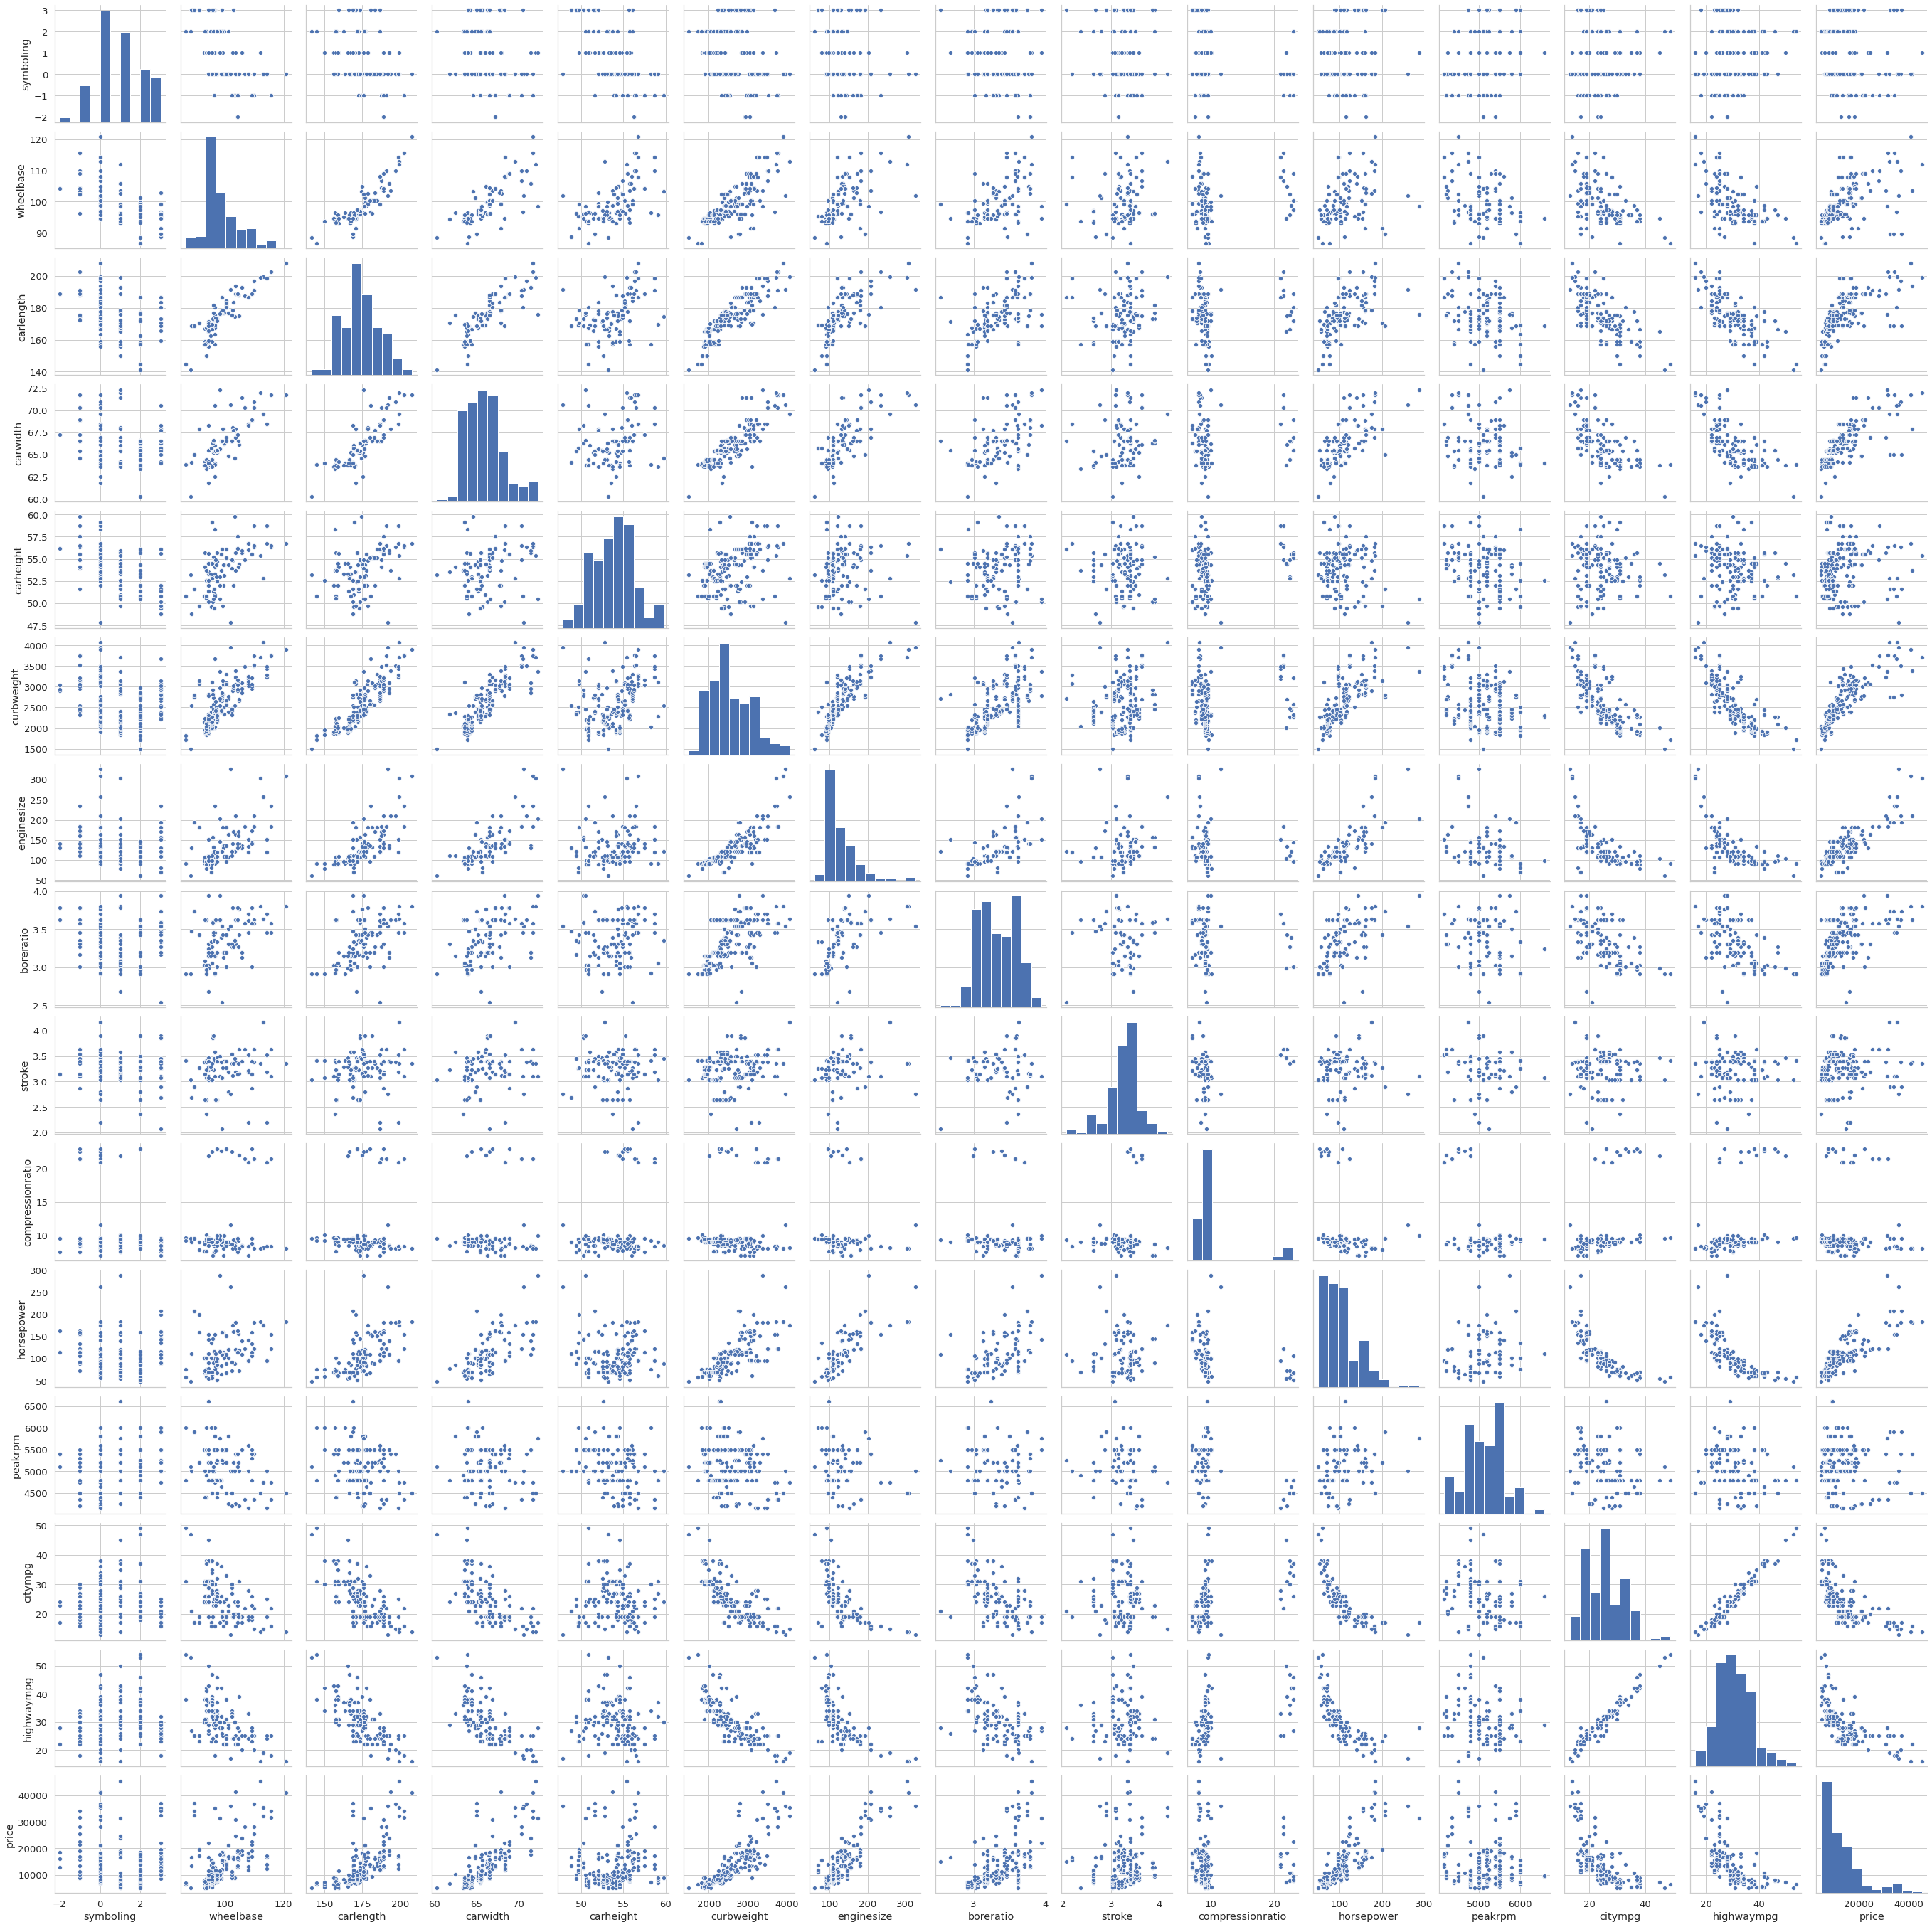

In [90]:
sns.pairplot(df);

Как мы можем видеть, следующиее переменные имет скорее не линейный характер взаимосвязи примерно со всеми остальными переменными: `stroke`, `carheight`, `peakrpm`.

### 4.

Посчитаем корреляцию между `price` и другими переменными. Чему равна корреляция между `price` и `horsepower`? 

In [91]:
# Построим матрицу корреляции, первый способ.
df.corr().style.background_gradient(cmap=sns.cubehelix_palette(as_cmap=True)).format("{:.2%}")

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
symboling,100.00%,-53.20%,-35.76%,-23.29%,-54.10%,-22.77%,-10.58%,-13.01%,-0.87%,-17.85%,7.09%,27.36%,-3.58%,3.46%,-8.00%
wheelbase,-53.20%,100.00%,87.46%,79.51%,58.94%,77.64%,56.93%,48.87%,16.10%,24.98%,35.33%,-36.05%,-47.04%,-54.41%,57.78%
carlength,-35.76%,87.46%,100.00%,84.11%,49.10%,87.77%,68.34%,60.65%,12.95%,15.84%,55.26%,-28.72%,-67.09%,-70.47%,68.29%
carwidth,-23.29%,79.51%,84.11%,100.00%,27.92%,86.70%,73.54%,55.91%,18.29%,18.11%,64.07%,-22.00%,-64.27%,-67.72%,75.93%
carheight,-54.10%,58.94%,49.10%,27.92%,100.00%,29.56%,6.71%,17.11%,-5.53%,26.12%,-10.88%,-32.04%,-4.86%,-10.74%,11.93%
curbweight,-22.77%,77.64%,87.77%,86.70%,29.56%,100.00%,85.06%,64.85%,16.88%,15.14%,75.07%,-26.62%,-75.74%,-79.75%,83.53%
enginesize,-10.58%,56.93%,68.34%,73.54%,6.71%,85.06%,100.00%,58.38%,20.31%,2.90%,80.98%,-24.47%,-65.37%,-67.75%,87.41%
boreratio,-13.01%,48.87%,60.65%,55.91%,17.11%,64.85%,58.38%,100.00%,-5.59%,0.52%,57.37%,-25.50%,-58.45%,-58.70%,55.32%
stroke,-0.87%,16.10%,12.95%,18.29%,-5.53%,16.88%,20.31%,-5.59%,100.00%,18.61%,8.09%,-6.80%,-4.21%,-4.39%,7.94%
compressionratio,-17.85%,24.98%,15.84%,18.11%,26.12%,15.14%,2.90%,0.52%,18.61%,100.00%,-20.43%,-43.57%,32.47%,26.52%,6.80%


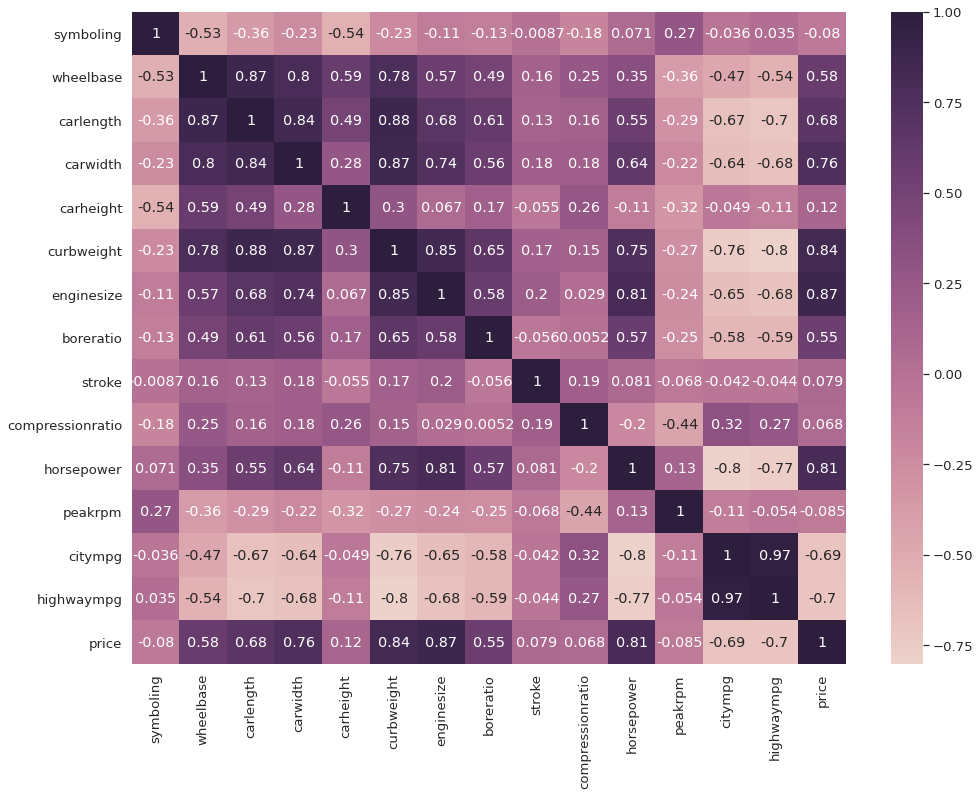

In [92]:
# Матрица корреляций вторым способом.
sns.heatmap(df.corr(), cmap=sns.cubehelix_palette(as_cmap=True), annot=True);

In [93]:
# Коэффициент корреляции Пирсона между price и horsepower.
stats.pearsonr(df.price, df.horsepower) 

(0.8081388225362216, 1.4834365732941758e-48)

In [94]:
# Коэффициент корреляции Спирмена между price и horsepower.
stats.spearmanr(df.price,df.horsepower)

SpearmanrResult(correlation=0.8546096111609129, pvalue=1.0967646925749196e-59)

In [95]:
# Коэффициент корреляции Кенделла между price и horsepower.
stats.kendalltau(df.price, df.horsepower)

KendalltauResult(correlation=0.6718632066246806, pvalue=2.736813628998727e-45)

### 5.

Чтобы не перегружать модель большим количеством предикторов, оставим только часть из них:

`'company', 'fueltype', 'aspiration','carbody', 'drivewheel', 'wheelbase', 'carlength','carwidth', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 'boreratio','horsepower'`

Последний шаг в подготовке данных: линейная регрессия в python не справляется с категориальными переменными (типом object в pandas), поэтому применим `pd.get_dummies()` и присоединим к полученному датасету столбцы с переменными других типов. Сколько колонок теперь имеется в датасете?

In [96]:
# Создаем датасет с преобразованными переменными.
df_dummy = pd.get_dummies(data=df[['company',
                                   'fueltype',
                                   'aspiration',
                                   'carbody',
                                   'drivewheel',
                                   'enginetype',
                                   'cylindernumber']], 
                          drop_first = True)

In [97]:
# Присоединяем его к первоначальному датасету, оставив только отобранные.
df = pd.concat([df_dummy, 
                 df[['wheelbase', 'carlength', 'carwidth', 'curbweight', 'enginesize', 'boreratio','horsepower', 'price']]], 
                axis=1)

In [98]:
print('В датасете теперь', df.columns.nunique(), 'колонок.')

В датасете теперь 49 колонок.


### 6.

Сначала построим небольшую модель всего с одним предиктором цены (price) – horsepower.

In [99]:
results = smf.ols('price ~ horsepower', df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     382.2
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           1.48e-48
Time:                        11:51:24   Log-Likelihood:                -2024.0
No. Observations:                 205   AIC:                             4052.
Df Residuals:                     203   BIC:                             4059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3721.7615    929.849     -4.003      0.0

Полученная модель объясняет 65% изменчивости цены.

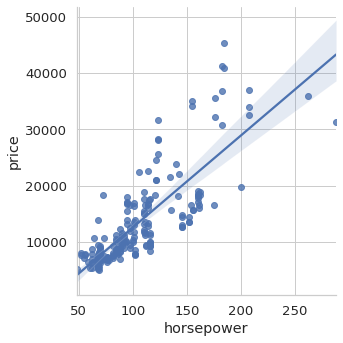

In [100]:
ax = sns.lmplot(x = 'horsepower', y = 'price', data = df)

### 7.

Теперь постоим две модели:

* модель со всеми предикторами
* модель со всеми предикторами, кроме марок машин

Обратим внимание на изменения в R2, коэффициентах и их значимости. Какую модель лучше оставить?  


In [101]:
# Модель со всеми предикторами
results = smf.ols('price ~ company_audi + company_bmw + company_buick + company_chevrolet +\
                  company_dodge + company_honda + company_isuzu + company_jaguar + company_mazda +\
                  company_mercury + company_mitsubishi + company_nissan + company_peugeot +\
                  company_plymouth + company_porsche + company_renault + company_saab + company_subaru +\
                  company_toyota + company_volkswagen + company_volvo + fueltype_gas + aspiration_turbo +\
                  carbody_hardtop + carbody_hatchback + carbody_sedan + carbody_wagon + drivewheel_fwd +\
                  drivewheel_rwd + enginetype_dohcv + enginetype_l + enginetype_ohc + enginetype_ohcf +\
                  enginetype_ohcv + enginetype_rotor + cylindernumber_five + cylindernumber_four+\
                  cylindernumber_six + cylindernumber_three + cylindernumber_twelve + cylindernumber_two +\
                  wheelbase + carlength + carwidth + curbweight + enginesize + boreratio + horsepower',
                  df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     81.09
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           4.86e-89
Time:                        11:53:02   Log-Likelihood:                -1804.2
No. Observations:                 205   AIC:                             3702.
Df Residuals:                     158   BIC:                             3858.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -3.472e+

In [102]:
# Mодель со всеми предикторами, кроме марок машин.
results = smf.ols('price ~ fueltype_gas + aspiration_turbo + carbody_hardtop + carbody_hatchback\
                    + carbody_sedan + carbody_wagon + drivewheel_fwd + drivewheel_rwd + enginetype_dohcv\
                    + enginetype_l + enginetype_ohc + enginetype_ohcf + enginetype_ohcv + enginetype_rotor\
                    + cylindernumber_five + cylindernumber_four + cylindernumber_six + cylindernumber_three\
                    + cylindernumber_twelve + cylindernumber_two + wheelbase + carlength + carwidth\
                    +curbweight + enginesize + boreratio + horsepower',
                  df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     72.32
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           9.86e-81
Time:                        11:53:05   Log-Likelihood:                -1881.6
No. Observations:                 205   AIC:                             3817.
Df Residuals:                     178   BIC:                             3907.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -1.7e+

Выбираем вторую модель, так как, там, где меньше предикторов, ведь R2 изменился не очень сильно, а часть марок вообще не значима.

In [103]:
# Другой способ построения модели.
X = sm.add_constant(df[['fueltype_gas', 'aspiration_turbo', 'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
                'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd','enginetype_dohcv', 'enginetype_l',
                'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv', 'enginetype_rotor', 'cylindernumber_five',
                'cylindernumber_four', 'cylindernumber_six', 'cylindernumber_three', 'cylindernumber_twelve',
                'cylindernumber_two', 'wheelbase', 'carlength', 'carwidth', 'curbweight', 'enginesize', 'boreratio',
                'horsepower']]) 
model = sm.OLS(df.price, X)  
results = model.fit() 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     72.32
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           9.86e-81
Time:                        11:53:13   Log-Likelihood:                -1881.6
No. Observations:                 205   AIC:                             3817.
Df Residuals:                     178   BIC:                             3907.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -1.7e+

Выбранная модель объясняет примерно 90% дисперсии. Среди предикторов, 10 из 27 оказались не значимыми (p > 0.05). Пример интерпретации: при единичном изменении показателя horsepower, цена возрастает на 86.8164. 